In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape


(70000, 784)

In [3]:
y.shape

(70000,)

In [4]:
28 * 28 # Dowód ze kazdy obrazek ma wymiary 28 x 28

784

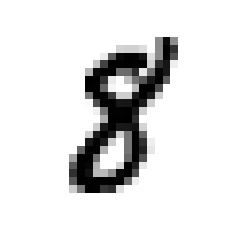

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[41]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

In [6]:
y[41] # czyli jest to liczba 5

'8'

In [7]:
import numpy as np

y = y.astype(np.uint8)

TERAZ DZIELIMY ZBIOR NA ZBIOR TESTOWY I TRENINGOWY

60tys na treningowy i 10 tys na testowy

In [8]:
X_train,X_test,y_train,y_test = X[:60000],X[60000:],y[:60000],y[60000:]

                       Klasyfikator Binarny dla 5 czyli albo jest 5 albo nie jest 5
                              
                              Wartość true dla 5 a dla pozostałych false

In [9]:
y_train_5 = (y_train == 5)
y_test_5  = (y_test == 5 )

                           Klasyfikator SGD -> Stochastyczny spadek wzdłuż gradientu
                             "random_state" uzywamy aby wyniki były powtarzalne

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clif = SGDClassifier(random_state=42)
sgd_clif.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clif.predict([some_digit])

array([False])

                                         Pomiar Wydajności

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clif,X_train,y_train_5,cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        return self;
    def predict(self,X):
        return np.zeros((len(X),1), dtype = bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

                      Znacznie lepszym pomiarem wydajnosci jest
                                 MACIERZ POMYŁEK

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clif, X_train, y_train_5, cv=3) #Dzielenie na Sprawdzian krzyżowy

         acierz pomyłek przy pomocy  confusion_matrix podajemy klase docelową i przeiwdywania klasty

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

                                         PRECYZJA KLASYFIKATORA

In [17]:
from sklearn.metrics import precision_score,recall_score

precision_score(y_train_5,y_train_pred) # Gdy uznaje ze rozpoznaje cyfre 5 nie myli sie w tylu procentach

0.8370879772350012

In [18]:
recall_score(y_train_5,y_train_pred) #Prawidłowo rozpoznaje 5

0.6511713705958311

                                ŚREDNIA HARMONICZNA PRECYZJI I PEŁNOŚCI

In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5,y_train_pred)

0.7325171197343846

In [20]:
y_scores = sgd_clif.decision_function([some_digit])
y_scores

array([-3624.39316868])

Kompromis pomiedzy precyzją a pełnością przy uzyciu  progów SGDClassifier korzysta z progru o wartosci 0 dlatego powyższy kod zwraca taki sam wynik jak metoda predict() 


In [21]:
threshold = 0 
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Podnosimy teraz próg 


In [22]:
threshold = 8000 
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Przy progu 8000  zmniejsza sie pelnosc i nie wykrywa 5 (chociaz liczba jest 5 ) Klasyfikator rozpoznaje ją przy progu 0 ale nie przy progu 8000 więc daje to nam dowód ze podniesienie progu zmniejsza pełność 

Teraz uzyskujemy wyniki wszystkich przykładów zestawu uczącego 

In [23]:
y_scores = cross_val_predict(sgd_clif, X_train, y_train_5, cv=3, method="decision_function")


In [24]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [25]:
from sklearn.metrics import precision_recall_curve

precision, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Generowanie wykresu precyzji i pełnosci 

In [26]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

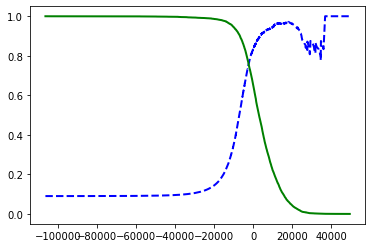

In [27]:
plot_precision_recall_vs_threshold(precision, recalls, thresholds)
plt.show()

Zakładamy ze potrzebujemy model o 90% precyzji 


In [28]:
tresholds_90_precision = thresholds[np.argmax(precision >=0.90)]

In [29]:
y_train_precision_90 = (y_scores >= tresholds_90_precision)

In [30]:
precision_score(y_train_5,y_train_precision_90) # precyzja 

0.9000345901072293

In [31]:
recall_score(y_train_5,y_train_precision_90) # pełność 

0.4799852425751706

In [32]:
from sklearn.metrics import roc_curve


In [33]:
fpr , tpr, thresholds = roc_curve(y_train_5,y_scores)

In [34]:
def plot_roc_curve(fpr, tpr, label = None):
  plt.plot(fpr, tpr, linewidth=2, label = label)
  plt.plot([0,1],[0,1],'k--')

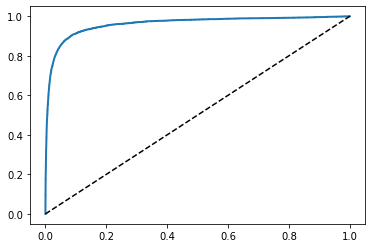

In [35]:
plot_roc_curve(fpr, tpr)

In [36]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train,y_train)
svm_clf.predict([some_digit])

array([8], dtype=uint8)

In [37]:
sgd_clif.fit(X_train,y_train)

SGDClassifier(random_state=42)

In [38]:
#some_digit
sgd_clif.predict([X[41]])

array([8], dtype=uint8)

In [39]:
sgd_clif.decision_function([X[41]])

array([[-30606.01613152, -12475.62868444,  -8780.49604951,
         -5659.90449646, -21260.61156933,  -9269.25780426,
        -21194.29718929, -25447.63205921,   3190.15202975,
         -5468.96363598]])

In [40]:
cross_val_score(sgd_clif, X_train, y_train, cv=3,scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))


In [42]:
y_train_pred = cross_val_score(sgd_clif, X_train_scaled, y_train, cv=3)


In [43]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

In [44]:
y_train_pred = cross_val_predict(sgd_clif, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [1]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

NameError: name 'plt' is not defined

In [46]:
from sklearn.neighbors import KNeighborsClassifier 

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [47]:
knn_clf.predict([some_digit])

array([[ True, False]])